<a href="https://colab.research.google.com/github/hpink97/tensorflow_keras_practice/blob/main/LSTM_S%26P500_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Create a Long-Short Term Memory Neural Network to predict future stock prices

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb



ModuleNotFoundError: No module named 'tensorflow.python'

In [2]:
data_URL = 'https://raw.githubusercontent.com/hpink97/ML_notebooks/data/'

data1 = pd.read_csv(f"{data_URL}sp500_1927_2020.csv")
data1.Date = pd.to_datetime(data1.Date)
data1 = data1[data1.Date >='2005-01-01']

data1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
19334,2005-01-03,1211.920044,1217.800049,1200.319946,1202.079956,1202.079956,1510800000
19335,2005-01-04,1202.079956,1205.839966,1185.390015,1188.050049,1188.050049,1721000000
19336,2005-01-05,1188.050049,1192.729980,1183.719971,1183.739990,1183.739990,1738900000
19337,2005-01-06,1183.739990,1191.630005,1183.270020,1187.890015,1187.890015,1569100000
19338,2005-01-07,1187.890015,1192.199951,1182.160034,1186.189941,1186.189941,1477900000


In [3]:
data2 = pd.read_csv(f"{data_URL}sp500_2012_2022.csv")
data2.Date = pd.to_datetime(data2.Date)

data2 = data2[data2.Date > data1.Date.max()]
data2 = data2.sort_values('Date')

data2.head()

,Date,Close/Last,Volume,Open,High,Low
539,2020-11-05,3510.45,--,3485.74,3529.05,3485.74
538,2020-11-06,3509.44,--,3508.34,3521.58,3484.34
537,2020-11-09,3550.50,--,3583.04,3645.99,3547.48
536,2020-11-10,3545.53,--,3543.26,3557.22,3511.91
535,2020-11-11,3572.66,--,3563.22,3581.16,3557.00


In [4]:
data_array = [data1[['Date','High']], data2[['Date','High']]]

df = pd.concat(data_array, ignore_index=True, sort=False)
##fill in missing days
df = df.set_index('Date').resample('1D').mean().bfill()
df['rolling_mean'] = df.rolling(window=3).mean()
df['Date'] = df.index
df = df.dropna()


df[df.rolling_mean <500]


,High,rolling_mean,Date
Date,,,


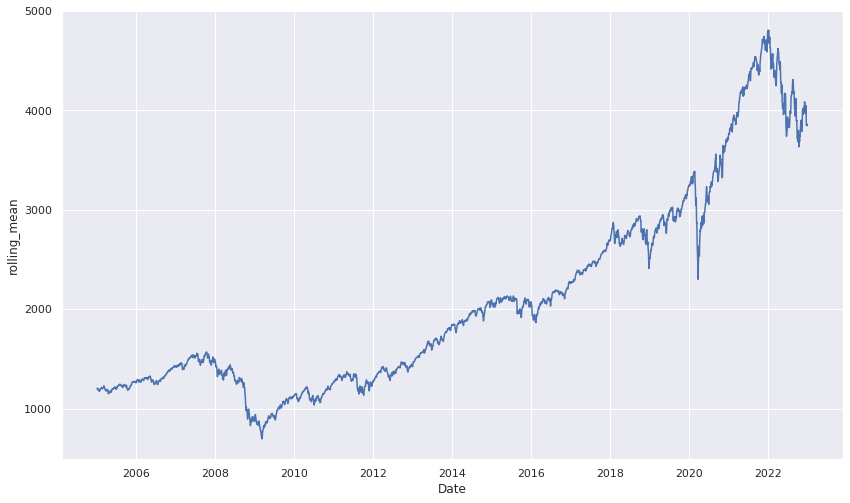

In [5]:
sns.set(rc={'figure.figsize':(14.0,8.27)})
sns.lineplot(data=df, x="Date", y="rolling_mean")

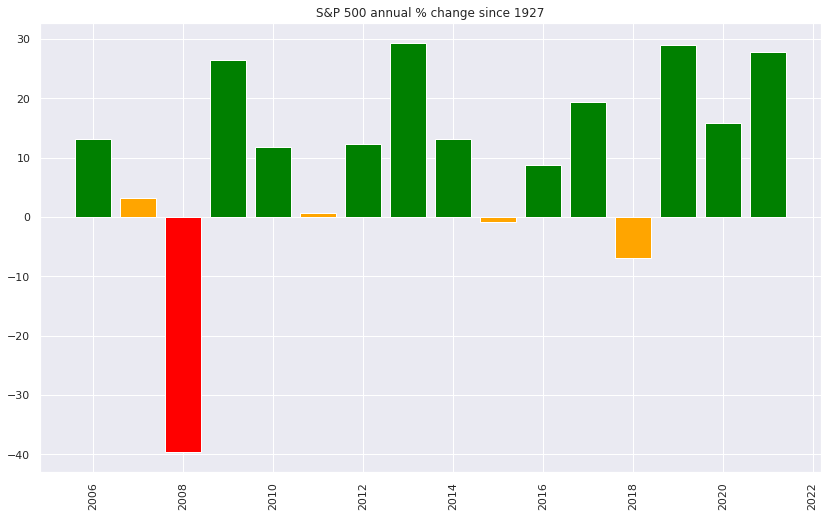

In [6]:
###calculate percentage change by year
pcnt_change = df.copy()
pcnt_change['year'] = df.Date.dt.year
pcnt_change['month'] = df.Date.dt.month
pcnt_change['day'] = df.Date.dt.day
pcnt_change = pcnt_change.loc[(pcnt_change.month ==12) &( pcnt_change.day ==31),['year','rolling_mean']]
pcnt_change['yr_pcnt_change'] = 100*pcnt_change['rolling_mean'].pct_change()
pcnt_change = pcnt_change.dropna()

x=pcnt_change.year
y=pcnt_change.yr_pcnt_change

profit_color = [{p< -10: 'red', -10<=p<=10: 'orange', p>8: 'green'}[True] for p in y]

plt.bar(x, y, color=profit_color)
plt.title('S&P 500 annual % change since 1927')
plt.xticks(rotation=90)
plt.show()

## Peform pre-processing of data for training

In [7]:
### convert to numpy array 7day rolling average 
df = df.dropna()
vals = df['rolling_mean'].values.reshape(-1, 1)
vals = vals.astype('float32') #COnvert values to float

vals[[0,69,5000,6500]]

array([[1205.4567],
       [1208.0667],
       [2903.2366],
       [3793.1233]], dtype=float32)

In [8]:
##scale all stock prices to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
vals = scaler.fit_transform(vals)
vals[[0,69,5000,6500]]

array([[0.12409073],
       [0.12472555],
       [0.5370352 ],
       [0.75347894]], dtype=float32)

In [9]:
##split into train-test split
train_size = int(len(vals) * 0.75)
validation_size = int(len(vals) * 0.88)
test_size = len(vals) - validation_size
train,validation, test = vals[0:train_size,:],vals[train_size:validation_size,:] ,vals[validation_size:len(vals),:]

print(f"S&P500 data has been into train ({len(train)} datapoints), validation ({len(validation)} datapoints) and test ({len(test)} datapoints). ")
print(f"Training data is from {df.Date[0]:%d/%m/%Y} until {df.Date[train_size-1]:%d/%m/%Y}")
print(f"Validation data is from  {df.Date[train_size]:%d/%m/%Y} until {df.Date[validation_size-1]:%d/%m/%Y}")
print(f"Testing data is from  {df.Date[validation_size]:%d/%m/%Y} until {df.Date[len(vals)-1]:%d/%m/%Y}")

##Test samples are after {df.Date[train_size]}"

S&P500 data has been into train (4925 datapoints), validation (853 datapoints) and test (789 datapoints). 
Training data is from 05/01/2005 until 30/06/2018
Validation data is from  01/07/2018 until 30/10/2020
Testing data is from  31/10/2020 until 28/12/2022


In [10]:
len(test)+len(train)+len(validation) == len(vals)

True

In [11]:
def to_sequences(dataset, n_past, n_future):
    x = []
    y = []

    for i in range(n_past, len(dataset) - n_future +1):
        #print(i)
        x.append(dataset[i - n_past:i,0])
        y.append(dataset[i + n_future - 1:i + n_future, 0])
        
    return np.array(x),np.array(y)



In [12]:
n_past = 35 ##7 weeks (approx 6mths) or previous data to train on
n_future = 14 ## predict two weeks into the future

trainX, trainY = to_sequences(train, n_past,n_future)
validX, validY = to_sequences(validation, n_past,n_future) 
testX, testY = to_sequences(test, n_past,n_future)

In [13]:
##reshape data for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, n_past))
validX = np.reshape(validX, (validX.shape[0], 1, n_past))
testX = np.reshape(testX, (testX.shape[0], 1, n_past))

print(f"S&P500 data has been into train ({len(trainX)} datapoints), validation ({len(validX)} datapoints) and test ({len(testX)} datapoints). ")


S&P500 data has been into train (4877 datapoints), validation (805 datapoints) and test (741 datapoints). 


In [14]:
#print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(units = 50, input_shape = (None, n_past)))
model.add(Dropout(0.08))
model.add(Dense(12))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                17200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 12)                612       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 17,825
Trainable params: 17,825
Non-trainable params: 0
_________________________________________________________________


In [15]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=30, 
                       verbose=1, mode='auto', restore_best_weights=True)

###fit to model 
history = model.fit(trainX, trainY, validation_data=(validX, validY),
          verbose=2, epochs=200, callbacks=[es])

Epoch 1/200
153/153 - 7s - loss: 0.0014 - val_loss: 0.0014 - 7s/epoch - 48ms/step
Epoch 2/200
153/153 - 1s - loss: 4.4676e-04 - val_loss: 0.0019 - 959ms/epoch - 6ms/step
Epoch 3/200
153/153 - 1s - loss: 3.1534e-04 - val_loss: 0.0013 - 967ms/epoch - 6ms/step
Epoch 4/200
153/153 - 1s - loss: 2.6658e-04 - val_loss: 0.0013 - 961ms/epoch - 6ms/step
Epoch 5/200
153/153 - 1s - loss: 2.4855e-04 - val_loss: 0.0014 - 1s/epoch - 7ms/step
Epoch 6/200
153/153 - 1s - loss: 2.4452e-04 - val_loss: 0.0011 - 991ms/epoch - 6ms/step
Epoch 7/200
153/153 - 1s - loss: 2.0851e-04 - val_loss: 0.0012 - 998ms/epoch - 7ms/step
Epoch 8/200
153/153 - 1s - loss: 2.0479e-04 - val_loss: 0.0014 - 973ms/epoch - 6ms/step
Epoch 9/200
153/153 - 1s - loss: 2.0291e-04 - val_loss: 0.0012 - 993ms/epoch - 6ms/step
Epoch 10/200
153/153 - 1s - loss: 1.9821e-04 - val_loss: 0.0013 - 913ms/epoch - 6ms/step
Epoch 11/200
153/153 - 1s - loss: 1.7641e-04 - val_loss: 0.0014 - 933ms/epoch - 6ms/step
Epoch 12/200
153/153 - 1s - loss: 1.836

In [16]:
###use model to predict values for the validation set and testing set
## use our original scaler to reverse_transform to return to original values (USD)
validationPredict =  scaler.inverse_transform(model.predict(validX).reshape(-1,1))
testPredict =  scaler.inverse_transform(model.predict(testX).reshape(-1,1))

24/24 [==============================] - 0s 2ms/step


In [17]:
## again inverse_transform to get real Y-values back to USD
validY = scaler.inverse_transform(validY.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

## As a best guess, use current S&P500 price, as a predictor of the price in 14 days time...

-If we can beat this with our model, shows our prediction is better than just saying S&P500 price will be the same in 2 weeks

In [18]:
def get_last_X_from_series(sequence):
  x1 =  [sequence[i,0,n_past-1] for i in np.arange(len(sequence))]
  x2 = np.array(x1)
  x3 = np.reshape(x2,(-1,1))
  x4 = scaler.inverse_transform(x3)

  return x4



validation_lastX_equals_Y =  get_last_X_from_series(validX)
test_lastX_equals_Y = get_last_X_from_series(testX)


## Asses predictions



In [19]:
def RMSE(y_true, y_pred, prefix):
  error = y_true-y_pred
  squared_error = error **2
  mean_squared_error = np.mean(squared_error)
  root_mean_squared_error = np.sqrt(mean_squared_error)
  return f"{prefix} RMSE = ${root_mean_squared_error:.2f}"


In [20]:
print(RMSE(validY, validation_lastX_equals_Y, 'validation_lastX_equals_Y'))
print(RMSE(validY, validationPredict, 'LSTM validation'))
print(RMSE(testY, test_lastX_equals_Y, 'test_lastX_equals_Y'))
print(RMSE(testY, testPredict, 'LSTM test'))


validation_lastX_equals_Y RMSE = $116.64
LSTM validation RMSE = $127.30
test_lastX_equals_Y RMSE = $127.63
LSTM test RMSE = $152.31
